# Fatigue Analysis of Timeseries Data using pylife

This notebook demonstrates how to perform a fatigue analysis on timeseries data using the pylife library. The steps include:

1. **Import Required Libraries**: Import necessary libraries such as pylife, pandas, and matplotlib.
2. **Load Timeseries Data**: Load the timeseries data from a file or other data source.
3. **Preprocess Data**: Clean and preprocess the data to ensure it is in the correct format for analysis.
4. **Perform Fatigue Analysis**: Use pylife's functions to analyze the fatigue life of the material based on the timeseries data.
5. **Visualize Results**: Plot the results of the fatigue analysis to visualize the fatigue life and other relevant metrics.

By following these steps, you will be able to assess the fatigue life of materials subjected to varying loads over time.

Import Required Libraries

In [51]:
!pip install pylife
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import pylife.stress.rainflow as rf


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load Timeseries Data

,elapsed time,receive time,header.stamp,topic,value
0,0.017999,1.739349e+09,1.739349e+09,/imu/data.linear_acceleration.y,10.340021
1,0.068948,1.739349e+09,1.739349e+09,/imu/data.linear_acceleration.y,10.526845
2,0.121911,1.739349e+09,1.739349e+09,/imu/data.linear_acceleration.y,10.419062
3,0.173837,1.739349e+09,1.739349e+09,/imu/data.linear_acceleration.y,10.566366
4,0.220717,1.739349e+09,1.739349e+09,/imu/data.linear_acceleration.y,10.390320


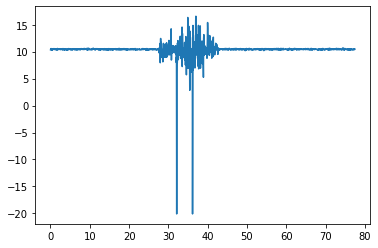

In [17]:
# Load the CSV data into a pandas dataframe
df = pd.read_csv('../data/acc_y_0.5_m_s.csv')
display(df.head())
plt.plot(df['elapsed time'], df['value'])


Preprocess Data

In [25]:
def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [31]:
def detect_spikes(data, threshold):
    spikes = data[np.abs(data.diff()) > threshold]
    return spikes

In [34]:
def remove_spikes(data, threshold):
    spikes = detect_spikes(data, threshold)
    data_cleaned = data.copy()
    data_cleaned[spikes.index] = np.nan
    return data_cleaned

In [35]:
def interpolate_data(data):
    return data.interpolate()

C:\Users\oezca\AppData\Local\Temp\ipykernel_18256\2763336314.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['smoothed_value'] = lowpass_filter(filtered_df['value'], cutoff, fs)
C:\Users\oezca\AppData\Local\Temp\ipykernel_18256\2763336314.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['rough_value'] = filtered_df['value'] - filtered_df['smoothed_value']


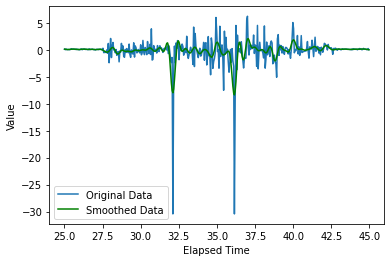

Variance of the rough component: 4.948601758771714


C:\Users\oezca\AppData\Local\Temp\ipykernel_18256\2763336314.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['value_cleaned'] = remove_spikes(filtered_df['value'], threshold)
C:\Users\oezca\AppData\Local\Temp\ipykernel_18256\2763336314.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['value_interpolated'] = interpolate_data(filtered_df['value_cleaned'])


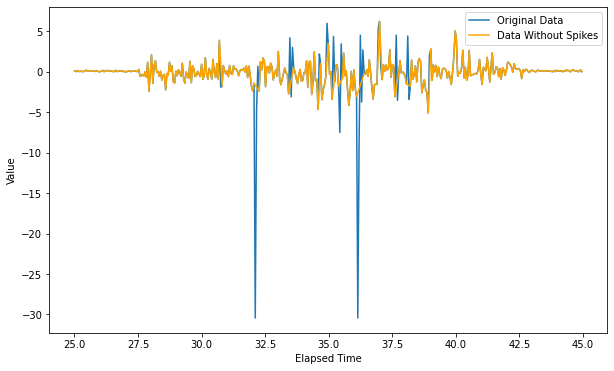

In [45]:
# Get Offset out of the data
offset = df['value'].iloc[0]
df['value'] = df['value'] - offset

# Shorten Time Series
filtered_df = df[(df['elapsed time'] >= 25) & (df['elapsed time'] <= 45)]

# Spike Detection
fs = 100 # Hz
cutoff = 10 # Hz

# # Smooth the Data
filtered_df['smoothed_value'] = lowpass_filter(filtered_df['value'], cutoff, fs)

# # Calc the rough part
filtered_df['rough_value'] = filtered_df['value'] - filtered_df['smoothed_value']

# # Calc the variance of the rough part
rough_variance = filtered_df['rough_value'].var()

plt.plot(filtered_df['elapsed time'], filtered_df['value'], label='Original Data')
plt.plot(filtered_df['elapsed time'], filtered_df['smoothed_value'], label='Smoothed Data', color='green')
plt.xlabel('Elapsed Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print(f"Variance of the rough component: {rough_variance}")
threshold = rough_variance
filtered_df['value_cleaned'] = remove_spikes(filtered_df['value'], threshold)
filtered_df['value_interpolated'] = interpolate_data(filtered_df['value_cleaned'])

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['elapsed time'], filtered_df['value'], label='Original Data')
plt.plot(filtered_df['elapsed time'], filtered_df['value_interpolated'], label='Data Without Spikes', color='orange')
plt.xlabel('Elapsed Time')
plt.ylabel('Value')
plt.legend()
plt.show()

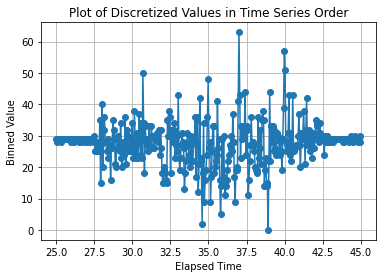

In [102]:
# Diskretsierung
num_bins = 64
bins = np.linspace(filtered_df['value_interpolated'].min(), filtered_df['value_interpolated'].max(), num_bins + 1)
filtered_df['binned_value'] = pd.cut(filtered_df['value_interpolated'], bins, labels=False, include_lowest=True)
plt.plot(filtered_df['elapsed time'], filtered_df['binned_value'], marker='o')
plt.xlabel('Elapsed Time')
plt.ylabel('Binned Value')
plt.title('Plot of Discretized Values in Time Series Order')
plt.grid(True)
plt.show()

Perform Analysis

'Hysteresen'

,from,to
0,28.0,29.0
1,28.0,29.0
2,28.0,29.0
3,28.0,29.0
4,28.0,29.0
...,...,...
94,28.0,29.0
95,28.0,29.0
96,30.0,28.0
97,30.0,28.0


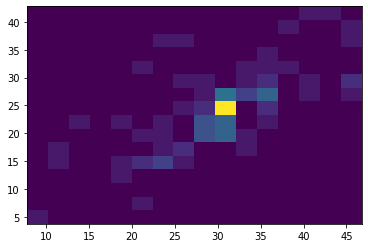

In [103]:
# Rainflow Counting
detector = rf.FourPointDetector(recorder=rf.LoopValueRecorder())
detector.process(filtered_df['binned_value'])
collective = detector.recorder.collective
display("Hysteresen", collective)

histogram = detector.recorder.histogram(16)

fr, to = histogram.index.levels[0], histogram.index.levels[1]
numpy_hist = np.flipud(histogram.values.reshape(len(fr),len(to)))
X, Y = np.meshgrid(fr.left, to.left)
plt.pcolormesh(X, Y, numpy_hist)


[]

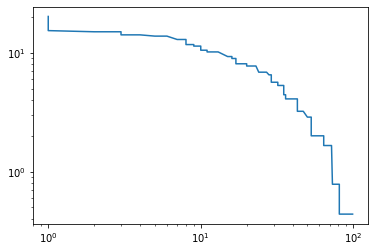

In [ ]:
# plot cumulated version of histogram
# TASK: Darstellung verstehen

df = pd.DataFrame({
'cycles': histogram.load_collective.cycles,
'amplitude': histogram.load_collective.amplitude,
}).sort_values('amplitude', ascending=False)

plt.plot(np.cumsum(df.cycles), df.amplitude)
plt.loglog()